# Cross-Market Association Rule Mining: US to Asian Stock Movement Patterns

## Executive Summary

This notebook implements a comprehensive **association rule mining framework** using the Apriori algorithm to discover predictive patterns between US and Asian market movements. The study analyzes a universe of products from the US and Asian markets from 2020-2023 to identify if US product movements can predict subsequent day Asian market behavior.

### Key Findings

**Discovery**: Withtin the limited universe in this experiment, discovered a tradable signal: When both Microsoft (MSFT) and Google (GOOGL) experience significant gains (>1%) on the same day, Hong Kong Tencent stock shows predictable downward movements the following day.

**Methodology**:
- Scanned in a universe of indices, major equities, commodities across US and 6 Asian markets
- Categorized daily movements into 5 buckets (up >1%, up ≤1%, flat, down <1%, down >1%)
- Applied temporal alignment to establish causality (US movements → following day Asian movements)
- Used Apriori algorithm with 5% minimum support and 40% minimum confidence thresholds

### Universe Coverage

**US Markets**: S&P 500, Dow Jones, major tech stocks (AAPL, MSFT, GOOGL, AMZN, TSLA), financials (JPM, GS), commodities (Gold, Oil, Silver, Copper), and blue-chip stocks

**Asian Markets**:
- **Japan**: Nikkei 225, Sony, SoftBank, Toyota, Hitachi, Nintendo, major banks
- **Hong Kong**: HSI, Tencent, CCB, China Mobile, HSBC  
- **India**: Nifty 50, Sensex, INFY, TCS, HDFC Bank, Reliance, Wipro
- **Australia**: ASX 200, CBA, BHP, RIO, CSL, Woolworths
- **Singapore**: DBS, Singtel, UOB
- **China**: Shanghai Composite, ICBC

### Technical Approach

1. **Data Collection**: Intraday percentage changes (Close-Open)/Open for all tickers
2. **Feature Engineering**: Categorical labeling of market movements
3. **Temporal Alignment**: US data for any day corresponds to Asian data shifted +1 day
4. **Association Mining**: Apriori algorithm to find frequent patterns
5. **Rule Filtering**: Focus on US→Asian patterns with significant movements
6. **Strategy Testing**: Historical backtesting and out-of-sample validation (Jan-Aug 2024)

### Risk Management

- Implemented 0.4% stop-loss cap on individual trades
- Out-of-sample testing on 2024 data
- Proper business day handling for market timing

### Conclusion

While the universe of tickers is quite limitied in this experiment, the results show potential in the methodology to successfully elicit out alpha rich tradable signals.

One such signal tested here was whenever microsoft and google where up more than 1%, tencent in Hong Kong was down more than 1% (45.7% of the time) and down 0-1% (14.5% of the time). This signal tested with a simple strategy of shorting tencent equity shares on trigger yielded a in-sample (2020-2023) daily sharpe of 0.585 and the annualized sharpe of 9.288. While the out-of-sample (Jan-Aug 2024) daily sharpe was 0.4424 and the annualized sharpe was 7.02.

Although, possibly higher returns can be generated using strategies around derivatives but due to lack of free F&O pricing data this experiment was limited to testing this simple strategy.

Overall, the notebook demonstrates a framwork with great potential to systematically scan for tradable signals.

---

<h2> Defining the Universe </h2>

In [92]:
import yfinance as yf
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore", message=r"datetime\.datetime\.utcnow\(\) is deprecated", category=DeprecationWarning)

# Define tickers for US and Asian markets, including country names
tickers = {
    'us': {
        'US ^GSPC': '^GSPC', 'US ^DJI': '^DJI', 'US AAPL': 'AAPL', 'US MSFT': 'MSFT',
        'US GOOGL': 'GOOGL', 'US AMZN': 'AMZN', 'US JPM': 'JPM', 'US GS': 'GS',
        'US PG': 'PG', 'US KO': 'KO', 'US XOM': 'XOM', 'US CVX': 'CVX', 'US BA': 'BA',
        'US CAT': 'CAT', 'US Gold': 'GC=F', 'US Oil': 'CL=F'
    },
    'asia': {
        'Japan ^N225': '^N225', 'Hong Kong ^HSI': '^HSI', 'Australia ^AXJO': '^AXJO', 'China 000001.SS': '000001.SS',
        'Japan Sony': '6758.T', 'Japan SoftBank': '9984.T', 'Japan MUFG': '8306.T', 'Japan SMFG': '8316.T', 'Japan Toyota': '7203.T', 'Japan Hitachi': '6501.T',
        'Hong Kong Tencent': '0700.HK', 'Hong Kong CCB': '0939.HK', 'Hong Kong China Mobile': '0941.HK',
        'India INFY': 'INFY.NS', 'India TCS': 'TCS.NS', 'India HDFCBANK': 'HDFCBANK.NS', 'India Reliance': 'RELIANCE.NS',
        'Australia CBA': 'CBA.AX', 'Australia BHP': 'BHP.AX', 'Australia RIO': 'RIO.AX', 'Australia CSL': 'CSL.AX',
        'Singapore DBS': 'D05.SI', 'Singapore Singtel': 'C6L.SI',
        'India Nifty 50': '^NSEI', 'India BSE Sensex': '^BSESN'
    }
}


# Add more tickers for US
tickers['us'].update({
    'US Tesla': 'TSLA',
    'US Netflix': 'NFLX',
    'US Silver': 'SI=F',
    'US Copper': 'HG=F'
})

# Add more tickers for Asia
tickers['asia'].update({
    'Japan Nintendo': '7974.T',
    'Hong Kong HSBC': '0005.HK',
    'India Wipro': 'WIPRO.NS',
    'Australia Woolworths': 'WOW.AX',
    'Singapore UOB': 'U11.SI',
    'China ICBC': '601398.SS'
})

<h2>Fetching Data</h2>

In [93]:
# Define date range for fetching data (2020-2023)
us_start_date = '2020-01-01'
asia_start_date = '2020-01-01'
end_date_us = '2023-12-31'
end_date_asia = '2024-01-01'

# create a date range of all business days between the start and end date
us_date_range = pd.date_range(start=us_start_date, end=end_date_us, freq='B')
asia_data_range = pd.date_range(start=asia_start_date, end=end_date_asia, freq='B')
total_days = len(us_date_range)

# Fetch data for US markets and perform basic preprocessing
us_data = yf.download(list(tickers['us'].values()), start=us_start_date, end=end_date_us)[['Open','Close']]
us_data.index = us_data.index.tz_localize(None)

# add in missing dates for us data
us_data = us_data.reindex(us_date_range)

# Compute the percentage change for each stock
us_data_pct_change = pd.DataFrame()

# Loop over each stock
for ticker in tickers['us'].values():
    # Compute the percentage change for the current stock
    us_pct_change = (us_data['Close', ticker] - us_data['Open', ticker]) / us_data['Open', ticker]

    # Add the percentage change to the DataFrame
    us_data_pct_change[ticker] = us_pct_change

us_data_pct_change = us_data_pct_change.fillna(0)
us_data_pct_change.head(20)

/tmp/ipython-input-3156164876.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  us_data = yf.download(list(tickers['us'].values()), start=us_start_date, end=end_date_us)[['Open','Close']]
[*********************100%***********************]  20 of 20 completed


,^GSPC,^DJI,AAPL,MSFT,GOOGL,AMZN,JPM,GS,PG,KO,XOM,CVX,BA,CAT,GC=F,CL=F,TSLA,NFLX,SI=F,HG=F
2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02,0.004062,0.008025,0.013874,0.011588,0.015032,0.012272,0.009300,0.014372,-0.008755,-0.005965,0.009396,0.005132,0.014518,0.010268,0.004216,-0.006818,0.013569,0.011377,0.000000,0.005858
2020-01-03,0.002631,0.002856,0.000942,0.001895,0.010030,0.005615,0.006109,-0.000086,0.003438,0.006811,-0.014157,-0.006323,0.006442,-0.002218,0.012483,0.030566,0.005698,-0.002693,-0.002319,0.001790
2020-01-06,0.008929,0.008357,0.020457,0.012414,0.034166,0.023054,0.012229,0.017484,0.001469,0.000366,0.007821,-0.005279,0.013483,0.007266,-0.008734,-0.006906,0.025132,0.039335,0.003994,0.008099
2020-01-07,-0.001444,-0.001938,-0.004836,-0.010921,-0.003820,0.001239,-0.010198,0.002085,-0.007243,-0.003673,-0.002979,0.000336,0.009035,-0.006583,0.008663,-0.003338,0.016602,-0.017000,0.016708,0.001071
2020-01-08,0.004465,0.006617,0.020292,0.007299,0.007327,-0.003198,0.009138,0.008826,0.002619,0.001474,-0.012552,-0.007170,-0.003099,0.005789,-0.014117,-0.051400,0.038928,0.023440,-0.016957,0.011482
2020-01-09,0.002655,0.003637,0.007779,0.001545,-0.001505,-0.004629,-0.004419,0.005221,0.010938,0.006182,0.008967,-0.000680,0.004150,-0.003383,-0.002571,-0.007168,-0.031704,-0.018538,0.005631,-0.005309
2020-01-10,-0.005016,-0.005306,-0.000869,-0.009090,-0.000357,-0.011657,-0.008308,-0.002636,0.000565,0.000901,-0.011297,-0.009190,-0.016808,-0.008952,0.004061,-0.009562,-0.007555,-0.023967,0.000000,0.003025
2020-01-13,0.005197,0.001318,0.017071,0.009397,0.003331,-0.000005,0.007416,0.003150,0.007097,0.010805,0.008671,0.001631,-0.006558,0.001979,-0.005779,-0.016260,0.063546,0.021459,-0.002448,-0.000175
2020-01-14,-0.000670,0.001529,-0.012693,-0.007712,-0.006535,-0.008717,0.006235,0.001386,0.000321,-0.004267,-0.002594,-0.001717,0.004807,-0.005222,-0.002780,0.003447,-0.011649,-0.016580,-0.010137,0.006474


In [94]:

# Fetch data for Asian markets
asia_data = yf.download(list(tickers['asia'].values()), start=asia_start_date, end=end_date_asia)[['Open','Close']]
asia_data.index = asia_data.index.tz_localize(None)

# add in missing dates for asia data
asia_data = asia_data.reindex(asia_data_range)
asia_data = asia_data.fillna(0)

# Compute the percentage change for each stock
asia_data_pct_change = pd.DataFrame()

# Loop over each stock
for ticker in tickers['asia'].values():
    # Compute the percentage change for the current stock
    asia_pct_change = (asia_data['Close', ticker] - asia_data['Open', ticker]) / asia_data['Open', ticker]

    # Add the percentage change to the DataFrame
    asia_data_pct_change[ticker] = asia_pct_change

/tmp/ipython-input-3313003607.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asia_data = yf.download(list(tickers['asia'].values()), start=asia_start_date, end=end_date_asia)[['Open','Close']]
[*********************100%***********************]  31 of 31 completed


<h2>Data Preprocessing</h2>

In [95]:
# Rename columns to include country and ticker
asia_data_pct_change.columns = tickers['asia'].keys()
us_data_pct_change.columns = tickers['us'].keys()


In [96]:
asia_data_pct_change_raw_vals = asia_data_pct_change.copy()

# Extend the function to label percentage changes with country, ticker, and ranges
def label_pct_change(x, ticker):
    if x is not None:
        if x > 0.01:
            return f"{ticker} up > 1%"
        elif 0 < x <= 0.01:
            return f"{ticker} up <= 1%"
        elif x==0:
            return f"{ticker} flat"
        elif -0.01 <= x < 0:
            return f"{ticker} down < 1%"
        else:
            return f"{ticker} down > 1%"

# Apply the labeling function to percentage change data, including country and ticker
us_data_pct_change = us_data_pct_change.apply(lambda col: col.apply(label_pct_change, args=(col.name,)))
asia_data_pct_change = asia_data_pct_change.apply(lambda col: col.apply(label_pct_change, args=(col.name,)))

# convert index to column for both dataframes
asia_data_pct_change.reset_index(inplace=True)
us_data_pct_change.reset_index(inplace=True)

# shift asia pct change data up by 2 days and us pct change data up by 1 day
asia_data_pct_change_shifted = asia_data_pct_change.shift(-2)
us_data_pct_change_shifted = us_data_pct_change.shift(-1)

# add a column to asia_data_pct_change_shifted called antecedant_date who's value is the previous date value in the date_range
asia_data_pct_change_shifted['antecedant_date'] = asia_data_pct_change_shifted['index'].shift(1)


In [97]:
# Merge US and Asian labeled data on antecedant_date and consequent_of_date columns
merged_data = pd.merge(us_data_pct_change, asia_data_pct_change_shifted, right_on='antecedant_date', left_on='index', how="left")

In [98]:
merged_data.head()

,index_x,US ^GSPC,US ^DJI,US AAPL,US MSFT,US GOOGL,US AMZN,US JPM,US GS,US PG,...,Singapore Singtel,India Nifty 50,India BSE Sensex,Japan Nintendo,Hong Kong HSBC,India Wipro,Australia Woolworths,Singapore UOB,China ICBC,antecedant_date
0,2020-01-01,US ^GSPC flat,US ^DJI flat,US AAPL flat,US MSFT flat,US GOOGL flat,US AMZN flat,US JPM flat,US GS flat,US PG flat,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,2020-01-02,US ^GSPC up <= 1%,US ^DJI up <= 1%,US AAPL up > 1%,US MSFT up > 1%,US GOOGL up > 1%,US AMZN up > 1%,US JPM up <= 1%,US GS up > 1%,US PG down < 1%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,2020-01-03,US ^GSPC up <= 1%,US ^DJI up <= 1%,US AAPL up <= 1%,US MSFT up <= 1%,US GOOGL up > 1%,US AMZN up <= 1%,US JPM up <= 1%,US GS down < 1%,US PG up <= 1%,...,Singapore Singtel down < 1%,India Nifty 50 down > 1%,India BSE Sensex down > 1%,Japan Nintendo down < 1%,Hong Kong HSBC down < 1%,India Wipro up <= 1%,Australia Woolworths up <= 1%,Singapore UOB down < 1%,China ICBC up <= 1%,2020-01-03
3,2020-01-06,US ^GSPC up <= 1%,US ^DJI up <= 1%,US AAPL up > 1%,US MSFT up > 1%,US GOOGL up > 1%,US AMZN up > 1%,US JPM up > 1%,US GS up > 1%,US PG up <= 1%,...,Singapore Singtel up <= 1%,India Nifty 50 down < 1%,India BSE Sensex down < 1%,Japan Nintendo down < 1%,Hong Kong HSBC down < 1%,India Wipro up <= 1%,Australia Woolworths up <= 1%,Singapore UOB up > 1%,China ICBC up <= 1%,2020-01-06
4,2020-01-07,US ^GSPC down < 1%,US ^DJI down < 1%,US AAPL down < 1%,US MSFT down > 1%,US GOOGL down < 1%,US AMZN up <= 1%,US JPM down > 1%,US GS up <= 1%,US PG down < 1%,...,Singapore Singtel up > 1%,India Nifty 50 up <= 1%,India BSE Sensex up <= 1%,Japan Nintendo up <= 1%,Hong Kong HSBC flat,India Wipro up <= 1%,Australia Woolworths up <= 1%,Singapore UOB up <= 1%,China ICBC flat,2020-01-07


In [99]:
print(f"Merged Data shape {merged_data.shape}")

Merged Data shape (1043, 54)


In [100]:
# Drop antecedant_date and consequent_of_date columns
merged_data.drop(columns=['antecedant_date', 'index_x','index_y'], inplace=True)
print(f"Merged Data shape {merged_data.shape}")

# Remove rows that have NaN values
merged_data.dropna(inplace=True)
print(f"Merged Data shape after dropping NaN rows {merged_data.shape}")

Merged Data shape (1043, 51)
Merged Data shape after dropping NaN rows (1041, 51)


In [101]:
# Convert merged data to list of lists
merged_data = merged_data.values.tolist()

In [102]:
# print total events
print(f"Total number of events: {sum([len(row) for row in merged_data])}")

# remove values from list that are like "%flat%"
merged_data = [[x for x in row if 'flat' not in x] for row in merged_data]
print(f"Total number of events post ommitting flats: {sum([len(row) for row in merged_data])}")

Total number of events: 53091
Total number of events post ommitting flats: 51506


In [104]:
# One-hot encoding
te = TransactionEncoder()
te_ary = te.fit(merged_data).transform(merged_data)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Apply Apriori algorithm
frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.05)


In [105]:
df.to_excel('data.xlsx')

<h2>Running Apriori on Data Set</h2>

In [106]:
# filter rules to have rows where antecedents are only from US and consequents are not from US
rules = rules[rules['antecedents'].apply(lambda x: all([i.startswith('US') for i in x]))]
rules = rules[rules['consequents'].apply(lambda x: not any([i.startswith('US') for i in x]))]

In [107]:
# filter rules to keep consequents have > symbol in them
rules = rules[rules['consequents'].apply(lambda x:  any([">" in i for i in x]))]


In [108]:
# filter rules to keep rules with confidence > 0.50
rules = rules[rules['confidence'] > 0.4]

In [109]:
rules.sort_values(by='confidence', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
106625,"(US AMZN up > 1%, US MSFT up > 1%, US GOOGL up...",(Hong Kong Tencent down > 1%),0.117195,0.356388,0.057637,0.491803,1.379966,1.0,0.015870,1.266462,0.311897,0.138568,0.210399,0.326764
62583,"(US PG up <= 1%, US GOOGL up > 1%)",(Hong Kong Tencent down > 1%),0.109510,0.356388,0.050913,0.464912,1.304511,1.0,0.011884,1.202816,0.262136,0.122685,0.168617,0.303885
62577,"(US Netflix up > 1%, US GOOGL up > 1%)",(Hong Kong Tencent down > 1%),0.129683,0.356388,0.059558,0.459259,1.288649,1.0,0.013341,1.190241,0.257370,0.139640,0.159834,0.313188
62571,"(US MSFT up > 1%, US GOOGL up > 1%)",(Hong Kong Tencent down > 1%),0.166186,0.356388,0.075889,0.456647,1.281321,1.0,0.016662,1.184520,0.263314,0.169892,0.155776,0.334793
62522,"(US AMZN up > 1%, US MSFT up > 1%)",(Hong Kong Tencent down > 1%),0.150817,0.356388,0.067243,0.445860,1.251052,1.0,0.013494,1.161461,0.236312,0.152838,0.139015,0.317270


<h2>Analysing MSFT & GOOGL -> Tencent Rule</h2>

In [110]:
us_data_pct_change_shifted[(us_data_pct_change_shifted['US MSFT'] == 'US MSFT up > 1%') & (us_data_pct_change_shifted['US GOOGL'] == 'US GOOGL up > 1%')]['index']

,index
0,2020-01-02
2,2020-01-06
22,2020-02-03
25,2020-02-06
27,2020-02-10
...,...
999,2023-11-01
1006,2023-11-10
1010,2023-11-16
1012,2023-11-20


<Axes: title={'center': 'Percentage Change of HK Tencent on days after US MSFT and US GOOGL up > 1%'}, ylabel='count'>

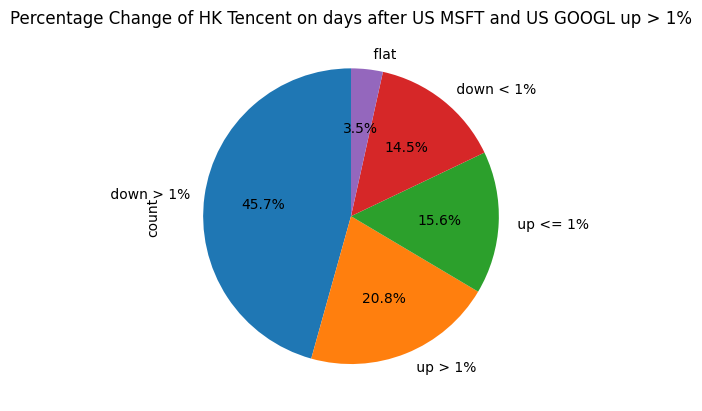

In [111]:
# get the dates where US MSFT up > 1% and US GOOGL up > 1% where there in us_data_pct_change_shifted dataframe
us_googl_msft_up_dates = us_data_pct_change_shifted[(us_data_pct_change_shifted['US MSFT'] == 'US MSFT up > 1%') & (us_data_pct_change_shifted['US GOOGL'] == 'US GOOGL up > 1%')]['index']


# get HK Tencent column from asia pct change shift from asia_data_pct_shift for dates from us_googl_msft_up_dates
hk_tencent_pct_change = asia_data_pct_change_shifted[asia_data_pct_change_shifted['antecedant_date'].isin(us_googl_msft_up_dates)]

hk_tencent_pct_change = hk_tencent_pct_change['Hong Kong Tencent']
# draw a pie chart of hk_tencent_pct_change values, and refactor labels to ommit "Hong Kong Tencent"
tencent_pct_change = hk_tencent_pct_change.apply(lambda x: x.replace("Hong Kong Tencent", ""))
tencent_pct_change.value_counts().plot.pie(autopct='%1.1f%%', startangle=90, title="Percentage Change of HK Tencent on days after US MSFT and US GOOGL up > 1%")




<h2>Calculating Delta Captured by the signal for 2020-2023</h2>

In [112]:
# get rows asia_data_pct_change_shifted where antecedant_date is in us_googl_msft_up_dates
hk_tencent_pct_change_dates = asia_data_pct_change_shifted[asia_data_pct_change_shifted['antecedant_date'].isin(us_googl_msft_up_dates)]['index']

# get the percentage change for Hong Kong Tencent for the dates in hk_tencent_pct_change
asia_data_pct_change_raw_vals.fillna(0,inplace=True)
asia_data_pct_change_raw_vals = asia_data_pct_change_raw_vals.reset_index()
hk_tencent_pct_change = asia_data_pct_change_raw_vals[asia_data_pct_change_raw_vals['index'].isin(hk_tencent_pct_change_dates)]['Hong Kong Tencent']

# add one to every value in hk_tencent_pct_change and get the product of all values
hk_tencent_pct_change = 1 + hk_tencent_pct_change
hk_tencent_pct_change_overall = hk_tencent_pct_change.prod()


In [113]:
print("compounded return on shorting tencent", 1 - hk_tencent_pct_change_overall)

compounded return on shorting tencent 0.4437207858811918


Incorporating a stop loss of 0.4% strategy

In [114]:
# Get rows asia_data_pct_change_shifted where antecedant_date is in us_googl_msft_up_dates
hk_tencent_pct_change_dates = asia_data_pct_change_shifted[
    asia_data_pct_change_shifted['antecedant_date'].isin(us_googl_msft_up_dates)
]['index']

# Get the percentage change for Hong Kong Tencent for the dates in hk_tencent_pct_change
asia_data_pct_change_raw_vals.fillna(0, inplace=True)
asia_data_pct_change_raw_vals = asia_data_pct_change_raw_vals.reset_index()
hk_tencent_pct_change = asia_data_pct_change_raw_vals[
    asia_data_pct_change_raw_vals['index'].isin(hk_tencent_pct_change_dates)
]['Hong Kong Tencent']

# Add a stop-loss cap at 0.4% (limit negative trades to a maximum loss of 0.4%)
stop_loss_threshold = 0.004  #
hk_tencent_pct_change_capped = hk_tencent_pct_change.apply(
    lambda x: stop_loss_threshold if x > stop_loss_threshold else x
)

# Add one to every value in hk_tencent_pct_change_capped and get the product of all values
hk_tencent_pct_change_capped = 1 + hk_tencent_pct_change_capped
hk_tencent_pct_change_overall = hk_tencent_pct_change_capped.prod()

# Output the result
print("Compounded return on shorting tencent with Stop-Loss Capped at 0.4%:", 1- hk_tencent_pct_change_overall)


Compounded return on shorting tencent with Stop-Loss Capped at 0.4%: 0.7715191437899245


# In Sample Sharpe Ratios

In [132]:
import numpy as np

# Assuming a risk-free rate of 0% for simplicity (replace by 0.000133 for 5 % annualised rate)
risk_free_rate = 0

# Calculate the daily returns
daily_returns = hk_tencent_pct_change_capped - 1
daily_returns = daily_returns * -1


# Calculate the average daily return
average_daily_return = daily_returns.mean()
print('average_daily_return : ', average_daily_return)


# Calculate the standard deviation of daily returns
std_dev_daily_return = daily_returns.std()
print('std_dev_daily_return : ', std_dev_daily_return)



# Calculate the daily Sharpe ratio
daily_sharpe_ratio = (average_daily_return - risk_free_rate) / std_dev_daily_return

# Annualize the Sharpe ratio (assuming 252 trading days in a year)
annualized_sharpe_ratio = daily_sharpe_ratio * np.sqrt(252)

print(f"Daily Sharpe Ratio: {daily_sharpe_ratio}")
print(f"Annualized Sharpe Ratio: {annualized_sharpe_ratio}")

average_daily_return :  0.008392504289991831
std_dev_daily_return :  0.0143439529457089
Daily Sharpe Ratio: 0.5850900600243889
Annualized Sharpe Ratio: 9.288016760402321


<h2>Testing Strategy for Jan 2024 - Aug 2024</h2>

In [115]:
# fetch open an close prices for US MSFT and US GOOGL for Jan - Aug 2024
us_data_2024 = yf.download(['MSFT','GOOGL'], start='2024-01-01', end='2024-08-31')[['Open','Close']]
us_data_2024.index = us_data_2024.index.tz_localize(None)

# keep only business days
us_data_2024 = us_data_2024.reindex(pd.date_range(start='2024-01-01', end='2024-08-31', freq='B'))

# Compute the percentage change for each stock
us_data_pct_change_2024 = pd.DataFrame()
for ticker in ['MSFT','GOOGL']:
    # Compute the percentage change for the current stock
    us_pct_change_2024 = (us_data_2024['Close', ticker] - us_data_2024['Open', ticker]) / us_data_2024['Open', ticker]

    # Add the percentage change to the DataFrame
    us_data_pct_change_2024[ticker] = us_pct_change_2024

us_data_pct_change_2024 = us_data_pct_change_2024.fillna(0)

# Apply the labeling function to percentage change data, including country and ticker
us_data_pct_change_2024 = us_data_pct_change_2024.apply(lambda col: col.apply(label_pct_change, args=(col.name,)))

# convert index to column for both dataframes
us_data_pct_change_2024.reset_index(inplace=True)

# get dates for which MSFT up > 1%	GOOGL up > 1% in us_data_pct_change_2024
us_googl_msft_up_dates_2024 = us_data_pct_change_2024[(us_data_pct_change_2024['MSFT'] == 'MSFT up > 1%') & (us_data_pct_change_2024['GOOGL'] == 'GOOGL up > 1%')]['index']

print(us_googl_msft_up_dates_2024.shape)
us_googl_msft_up_dates_2024.head()

/tmp/ipython-input-391227282.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  us_data_2024 = yf.download(['MSFT','GOOGL'], start='2024-01-01', end='2024-08-31')[['Open','Close']]
[*********************100%***********************]  2 of 2 completed

(14,)


,index
5,2024-01-08
6,2024-01-09
24,2024-02-02
29,2024-02-09
51,2024-03-12


In [116]:
import numpy as np

def get_next_business_day(date):
    date = date.strftime('%Y-%m-%d')
    return np.busday_offset(date, 1, roll='forward')

us_googl_msft_up_dates_2024 = us_googl_msft_up_dates_2024.apply(lambda x: get_next_business_day(x))

In [117]:
# fetch open close prices for HK Tencent from Jan - Aug 2024
hk_tencent_prices_2024 = yf.download(['0700.HK'], start='2024-01-01', end='2024-08-31')[['Open','Close']]
hk_tencent_prices_2024.index = hk_tencent_prices_2024.index.tz_localize(None)


# keep only business days
hk_tencent_prices_2024 = hk_tencent_prices_2024.reindex(pd.date_range(start='2024-01-01', end='2024-08-31', freq='B'))

# # Compute the percentage change
hk_tencent_pct_change_2024 = pd.DataFrame()
hk_tencent_pct_change_2024['change'] = (hk_tencent_prices_2024['Close'] - hk_tencent_prices_2024['Open']) / hk_tencent_prices_2024['Open']
hk_tencent_pct_change_2024['change'] = hk_tencent_pct_change_2024['change'].fillna(0)


# Add a stop-loss cap at 0.4% (limit negative trades to a maximum loss of 0.4%)
stop_loss_threshold = 0.004  #
hk_tencent_pct_change_2024_capped = hk_tencent_pct_change_2024.apply(
    lambda x: stop_loss_threshold if x.change > stop_loss_threshold else x,axis=1
)

hk_tencent_pct_change_2024_capped['change'] = 1+hk_tencent_pct_change_2024_capped['change']

# get dates in hk_tencent_pct_change_2024 that are there in us_googl_msft_up_dates_2024
hk_tencent_pct_change_2024_capped.reset_index(inplace=True)


/tmp/ipython-input-1841668692.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hk_tencent_prices_2024 = yf.download(['0700.HK'], start='2024-01-01', end='2024-08-31')[['Open','Close']]
[*********************100%***********************]  1 of 1 completed


In [118]:
# hk_tencent_pct_change_2024 values for dates in us_googl_msft_up_dates_2024
hk_tencent_pct_change_2024_capped = hk_tencent_pct_change_2024_capped[hk_tencent_pct_change_2024_capped['index'].isin(us_googl_msft_up_dates_2024)]


In [122]:
hk_tencent_pct_change_2024_capped.head(40)

,index,change
6,2024-01-09,0.991608
7,2024-01-10,0.993617
25,2024-02-05,1.004000
30,2024-02-12,1.000000
52,2024-03-13,0.997255
54,2024-03-15,1.002827
70,2024-04-08,1.000655
84,2024-04-26,1.004000
98,2024-05-16,0.992500
121,2024-06-18,0.988464


In [124]:
# Calculate the overall percentage change for 2024
hk_tencent_pct_change_2024_overall = hk_tencent_pct_change_2024_capped['change'].prod()

# Output the result
print("Overall Tencent Percentage Change for 2024 with Stop-Loss Capped at 0.4%:", hk_tencent_pct_change_2024_overall)

Overall Tencent Percentage Change for 2024 with Stop-Loss Capped at 0.4%: 0.9578873918215984


# **Out of Sample Sharpe Ratios**

In [123]:
import numpy as np

# Assuming a risk-free rate of 0% for simplicity
risk_free_rate = 0

# Calculate the daily returns
daily_returns = hk_tencent_pct_change_2024_capped['change'] - 1
daily_returns = daily_returns * -1


# Calculate the average daily return
average_daily_return = daily_returns.mean()
print('average_daily_return : ', average_daily_return)


# Calculate the standard deviation of daily returns
std_dev_daily_return = daily_returns.std()
print('std_dev_daily_return : ', std_dev_daily_return)



# Calculate the daily Sharpe ratio
daily_sharpe_ratio = (average_daily_return - risk_free_rate) / std_dev_daily_return

# Annualize the Sharpe ratio (assuming 252 trading days in a year)
annualized_sharpe_ratio = daily_sharpe_ratio * np.sqrt(252)

print(f"Daily Sharpe Ratio: {daily_sharpe_ratio}")
print(f"Annualized Sharpe Ratio: {annualized_sharpe_ratio}")

average_daily_return :  0.003046365741750815
std_dev_daily_return :  0.006885872525584721
Daily Sharpe Ratio: 0.4424080943165775
Annualized Sharpe Ratio: 7.023010773382032
